In [74]:
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torchvision
import cv2
import torch.nn as nn
import nibabel as nib
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [75]:
os.chdir("G:/rsna-2023-abdominal-trauma-detection/")

In [76]:
# os.listdir()

In [33]:
import pydicom as dicom

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data

In [34]:
p_s = glob("G:/rsna-2023-abdominal-trauma-detection/train_images/*/*")
s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in p_s}
len(p_s)

4711

In [35]:
seg_files = glob("./segmentations/*.nii")
len(seg_files)

206

In [36]:
s_id = seg_files[180].split("\\")[-1].split(".")[0]
p_id = s_id_p_id[s_id]

In [37]:
# import math

# y_total = []
# z_total = []
# for seg_file in tqdm(seg_files):
#     mask = nib.load(seg_file).get_fdata()[:, ::-1, ::-1].transpose(2,1,0)
#     #print(mask.shape)
#     xs,ys,zs = np.where(mask == 4)
#     x_m, y_m,z_m = np.mean(xs), np.mean(ys),np.mean(zs)
#     y_total.append(y_m)
#     z_total.append(z_m)
# y_filtered = [y for y in y_total if not math.isnan(y)]
# z_filtered = [z for z in z_total if not math.isnan(z)]
# print(len(y_filtered), len(z_filtered))
# print(np.mean(y_filtered),np.mean(y_filtered))

In [38]:
# np.mean(y_filtered), np.mean(z_filtered)
# cls 3 lkidney 300.0794, 345.5285
# cls 2 spleen 304, 380
# cls 5 bowel 214 287
# cls 1 liver 239 180
# cls 4 rkidney 183,183

In [39]:
# y_total = []
# z_total = []
# for seg_file in tqdm(seg_files):
#     mask = nib.load(seg_file).get_fdata()[:, ::-1, ::-1].transpose(2,1,0)
#     #print(mask.shape)
#     xs,ys,zs = np.where(mask == 3)
#     x_m, y_m,z_m = np.mean(xs), np.mean(ys),np.mean(zs)
#     y_total.append(y_m)
#     z_total.append(z_m)
# print(np.mean(y_total),np.mean(z_total))

In [40]:
trn_df = pd.read_csv("./train.csv")
s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in glob("./train_images/*/*")}
s_ids = s_id_p_id.keys()

p_ids = [int(s_id_p_id[x]) for x in s_ids]
p_s_df = pd.DataFrame({"series_id":s_ids,"patient_id":p_ids})
trn_df = p_s_df.merge(trn_df,on="patient_id",how="left")


In [41]:
import torch
torch.cuda.empty_cache()

In [42]:
# image_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/*/*/*.jpeg")
# cv2.imread(image_paths[0]).max()

In [43]:
os.getcwd()

'G:\\rsna-2023-abdominal-trauma-detection'

In [44]:
list(glob("./models/vit*"))[::5]

['./models\\vit0919_model_0_0.pth',
 './models\\vit_spleen_0_3labels_0927.pth',
 './models\\vit_spleen_ep0_fold1_3labels_0930_cropped.pth',
 './models\\vit_spleen_ep1_fold2_3labels_0930_cropped.pth',
 './models\\vit_spleen_ep2_fold3_3labels_0930_cropped.pth']

In [45]:
list(glob("./models/resnet*"))[:4]

['./models\\resnet18LSTM',
 './models\\resnet50dLSTM',
 './models\\resnet_bowel_ep0_fold0_3labels_0929_cropped.pth',
 './models\\resnet_bowel_ep0_fold0_3labels_0930_cropped.pth']

### GRU model

In [46]:
import torch.nn as nn
from itertools import repeat
import timm
class SpatialDropout(nn.Module):
    def __init__(self, drop=0.5):
        super(SpatialDropout, self).__init__()
        self.drop = drop
        
    def forward(self, inputs, noise_shape=None):
        """
        @param: inputs, tensor
        @param: noise_shape, tuple
        """
        outputs = inputs.clone()
        if noise_shape is None:
            noise_shape = (inputs.shape[0], *repeat(1, inputs.dim()-2), inputs.shape[-1]) 
        
        self.noise_shape = noise_shape
        if not self.training or self.drop == 0:
            return inputs
        else:
            noises = self._make_noises(inputs)
            if self.drop == 1:
                noises.fill_(0.0)
            else:
                noises.bernoulli_(1 - self.drop).div_(1 - self.drop)
            noises = noises.expand_as(inputs)    
            outputs.mul_(noises)
            return outputs
            
    def _make_noises(self, inputs):
        return inputs.new().resize_(self.noise_shape)


import torch
from torch import nn
import torch.nn.functional as F

from typing import Dict, Optional
 
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor


    
class MLPAttentionNetwork(nn.Module):
 
    def __init__(self, hidden_dim, attention_dim=None):
        super(MLPAttentionNetwork, self).__init__()
 
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim
        if self.attention_dim is None:
            self.attention_dim = self.hidden_dim
        # W * x + b
        self.proj_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=True)
        # v.T
        self.proj_v = nn.Linear(self.attention_dim, 1, bias=False)
 
    def forward(self, x):
        """
        :param x: seq_len, batch_size, hidden_dim
        :return: batch_size * seq_len, batch_size * hidden_dim
        """
        # print(f"x shape:{x.shape}")
        batch_size, seq_len, _ = x.size()
        # flat_inputs = x.reshape(-1, self.hidden_dim) # (batch_size*seq_len, hidden_dim)
        # print(f"flat_inputs shape:{flat_inputs.shape}")
        
        H = torch.tanh(self.proj_w(x)) # (batch_size, seq_len, hidden_dim)
        # print(f"H shape:{H.shape}")
        
        att_scores = torch.softmax(self.proj_v(H),axis=1) # (batch_size, seq_len)
        # print(f"att_scores shape:{att_scores.shape}")
        
        attn_x = (x * att_scores).sum(1) # (batch_size, hidden_dim)
        # print(f"attn_x shape:{attn_x.shape}")
        return attn_x

In [47]:
class CFG:
    seed=42
    device='GPU'
    nprocs=1 # [1, 8]
    # num_workers=num_workers_
    # train_bs=train_bs_
    # valid_bs=valid_bs_
    fold_num=5
    img_size=224
    model_arch="resnest50d"
    seq_len=16
    dropout=0.1

In [48]:
class RSNAClassifier(nn.Module):
    def __init__(self, model_arch, hidden_dim=256, seq_len=24, pretrained=False,num_classes=3):
        super().__init__()
        self.seq_len = seq_len
        self.model = timm.create_model(model_arch, in_chans=1, pretrained=pretrained)
        cnn_feature = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        
        self.spatialdropout = SpatialDropout(CFG.dropout)
        self.gru = nn.GRU(cnn_feature, hidden_dim, 2, batch_first=True, bidirectional=True)
        self.mlp_attention_layer = MLPAttentionNetwork(2 * hidden_dim)
        self.logits = nn.Sequential(
            nn.Linear(hidden_dim*2, 128),
            nn.ReLU(),
            nn.Dropout(CFG.dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x): # (B, seq_len, H, W)
        bs = x.size(0) 
        x = x.reshape(bs*self.seq_len, 1, x.size(2), x.size(3)) # (B*seq_len, 1, H, W)
        features = self.model(x)   
        if "res" in CFG.model_arch:                             
            features = self.pooling(features).view(bs*self.seq_len, -1) # (B*seq_len, cnn_feature)
        features = self.spatialdropout(features)                # (B*seq_len, cnn_feature)
        # print(features.shape)
        features = features.reshape(bs, self.seq_len, -1)       # (B, seq_len, cnn_feature)
        features, _ = self.gru(features)                        # (B, seq_len, hidden_dim*2)
        atten_out = self.mlp_attention_layer(features)          # (B, hidden_dim*2)
        pred = self.logits(atten_out)                           # (B, 1)
        pred = pred.view(bs, -1)                                # (B, 1)
        return pred

In [49]:
test_image_list = []

In [50]:
def dicom_to_image(dicom_image):
    """
    Read the dicom file and preprocess appropriately.
    """
    pixel_array = dicom_image.pixel_array
    
    if dicom_image.PixelRepresentation == 1:
        bit_shift = dicom_image.BitsAllocated - dicom_image.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = dicom.pixel_data_handlers.util.apply_modality_lut(new_array, dicom_image)
    
    if dicom_image.PhotometricInterpretation == "MONOCHROME1":
        pixel_array = 1 - pixel_array
    
    # transform to hounsfield units
    intercept = dicom_image.RescaleIntercept
    slope = dicom_image.RescaleSlope
    pixel_array = pixel_array * slope + intercept
    
    # windowing
    window_center = int(dicom_image.WindowCenter)
    window_width = int(dicom_image.WindowWidth)
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    pixel_array = pixel_array.copy()
    pixel_array[pixel_array < img_min] = img_min
    pixel_array[pixel_array > img_max] = img_max
    
    # normalization
    pixel_array = (pixel_array - pixel_array.min())/(pixel_array.max() - pixel_array.min())
    
    return (pixel_array * 255).astype(np.uint8)
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

In [51]:
trn_df.patient_id.values[-200]

7190

In [52]:
from PIL import Image
def prepare_1ch_images(img_paths):
    img_list = []
    for ii in range(0, len(img_paths)):
        img = load_dicom(img_paths[ii])
        img_tmp = cv2.resize(img,(224,224))
        # img_tmp = cv2.imread(image_paths[iid+jj])[:,:,0]
        
        # img_tmp = Image.fromarray(dicom_to_image(dicom.read_file(image_paths[iid+jj])))
        # img_tmp = transform(img_tmp)

        test_image_list[-1].append(img_tmp)
        # print("minmax", img.max(),img.min())
        # img_tmp = img[images_coords[0]:images_coords[0]+224,images_coords[1]:images_coords[1]+224]
        img_tmp = torch.tensor(img_tmp.astype(np.float32)).to(torch.float32)
        img_tmp = torch.unsqueeze(img_tmp,0)
        img_list.append(img_tmp)

    return torch.stack(img_list,0)

def prepare_2ch_images(img_paths):
    img_list = []
    for ii in range(0, len(img_paths)):
        img = np.array((Image.open(img_paths[ii])))
        img_list.append(img[:,:,1:].transpose(2,0,1))
    
    return np.array(img_list)

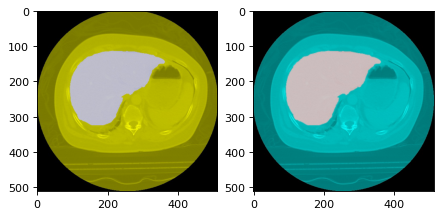

In [53]:

import matplotlib
matplotlib.rcParams['figure.dpi'] = 80
# open in train_label_simple
plt.subplot(1,2,1);plt.imshow(np.array(Image.open('./cropped_organs_sid\\14543\\51645\\14543_51645_1_139.jpeg')))
# open in 2-5-d resnet18
plt.subplot(1,2,2);plt.imshow(cv2.imread('./cropped_organs_sid\\14543\\51645\\14543_51645_1_139.jpeg'))


['./cropped_organs_sid\\51476\\53156\\51476_53156_1_21.jpeg', './cropped_organs_sid\\51476\\53156\\51476_53156_1_22.jpeg', './cropped_organs_sid\\51476\\53156\\51476_53156_1_23.jpeg', './cropped_organs_sid\\51476\\53156\\51476_53156_1_24.jpeg', './cropped_organs_sid\\51476\\53156\\51476_53156_1_25.jpeg', './cropped_organs_sid\\51476\\53156\\51476_53156_1_26.jpeg', './cropped_organs_sid\\51476\\53156\\51476_53156_1_27.jpeg', './cropped_organs_sid\\51476\\53156\\51476_53156_1_28.jpeg', './cropped_organs_sid\\51476\\53156\\51476_53156_1_29.jpeg', './cropped_organs_sid\\51476\\53156\\51476_53156_1_30.jpeg']
(399, 2, 512, 512)


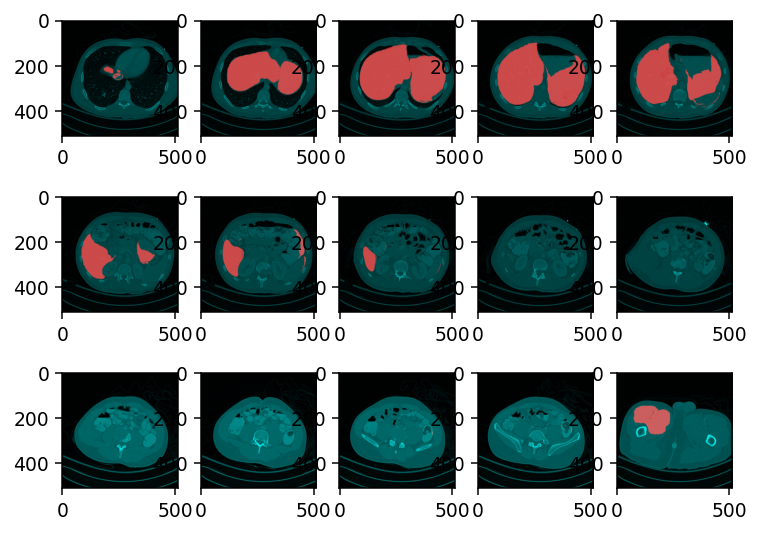

In [54]:
matplotlib.rcParams['figure.dpi'] = 135
show_folder = np.random.choice(glob("./cropped_organs_sid/*/*"))
show_paths = sorted(glob(f"{show_folder}/*_*_1_*.jpeg"),key=lambda x: int(x.split("_")[-1].split(".")[0]))
print(show_paths[:10])
img_arr = prepare_2ch_images(show_paths)
print(img_arr.shape)
for ii in range(15):
    show_slice = int(img_arr.shape[0]/15*ii)
    show_mask = img_arr[show_slice][1]
    show_jpg = img_arr[show_slice][0]

    plt.subplot(3,5,ii+1);plt.imshow(np.stack([show_mask,show_jpg,show_jpg],axis=2).astype(np.int32))

In [55]:
from albumentations import Compose, Resize
transform = Compose([Resize(224,224)])

def prepare_gru_images(img_paths):
    img_list = []
    img_paths = sorted(img_paths,key=lambda x:int(x.split("_")[-1].split(".")[0]))
    for ii in range(0, len(img_paths)):
        # img = load_dicom(img_paths[ii])
        img_tmp = cv2.imread(img_paths[ii])[:,:,1]
        img_tmp = cv2.resize(img_tmp,(224,224))
        
        # img_tmp = Image.fromarray(dicom_to_image(dicom.read_file(image_paths[iid+jj])))
        # img_tmp = transform(img_tmp)

        # test_image_list[-1].append(img_tmp)
        # print("minmax", img.max(),img.min())
        # img_tmp = img[images_coords[0]:images_coords[0]+224,images_coords[1]:images_coords[1]+224]
        img_list.append(img_tmp)
    image = np.stack(img_list, axis=2)
    image = transform(image=image)["image"]
    image = np.transpose(image, (2, 0, 1)) # seq_len*img_size*img_size; 0-1
    # print(image.shape,image.max(),image.min())
    image = torch.from_numpy(image.astype(np.float32)).to(torch.float32).unsqueeze(dim=0).unsqueeze(dim=0)
    image = F.interpolate(image, [seq_len,224,224]).squeeze()

    return torch.unsqueeze(image,0).to(torch.float32)

In [98]:
target_col = "liver_low"
target_col = "liver_high"
target_cols = ["liver_healthy","liver_low","liver_high"]
np.unique(trn_df[f"{target_col}"].values,return_counts=True)

model_name = "gru"
org_name = "lkidney"
org_name = "liver"
# org_name = "rkidney"
# org_name = "spleen"
# org_name = "all"
epoch = 3
version = "1007"
version = "1008"
fold = 0

# target_cols = ["kidney_healthy","kidney_low","kidney_high"]

# target_cols = ["spleen_healthy","spleen_low","spleen_high"]
# org_name = "bowel"
# target_cols = ["bowel_healthy","bowel_injury","extravasation_healthy","extravasation_injury"]
VOLUME = (128, 224, 224)
VOLUME = (128, 256, 256)
WINDOW_STEP = 2
# Odd Number Only
WINDOW_WIDTH = 3
PAD_ENDING = True
SLICE_NUM = (128-1)//2 + 1
folder = "cropped_organs_sid"
# target_cols = ["kidney_low","kidney_high"]

org_segs = ["1"]
# org_segs = ["2"]
target_cols = ["liver_healthy","liver_low","liver_high"]
# model_arch="resnest50d" # tf_efficientnetv2_s, resnest50d
# img_size=224
# seq_len = 24
# model = RSNAClassifier(model_arch, hidden_dim=256, seq_len=seq_len, pretrained=True,num_classes=len(target_cols))
# model.load_state_dict(torch.load(f"./models/resnet50dLSTM/resnest50d_lkidney_seq24_size224_fold0_epoch0_1004_3ch.pth")["model"])
# model = model.cuda()
# model2 = RSNAClassifier(CFG.model_arch, hidden_dim=256, seq_len=seq_len, pretrained=True,num_classes=len(target_cols))
# model2.load_state_dict(torch.load(f"./models/resnet50dLSTM/resnest50d_lkidney_seq24_size224_fold0_epoch0_1004_3ch.pth")["model"])

# model.load_state_dict(torch.load(f"./models/single/resnet_spleen_ep2_fold0_3labels_1005_3ch_best.pth", map_location=torch.device('cpu')))
# "./models/resnet_liver_ep2_3labels_0929.pth"
# import timm
# model = timm.create_model(
#     'vit_base_patch16_224',
#     pretrained=False,
#     num_classes=14,
#     in_chans=1
# )
# model.load_state_dict(torch.load(f"./vit0919_model_1_2.pth", map_location=torch.device('cpu')))
print(org_segs, model_name, org_name,target_cols,VOLUME, folder,version)

['1'] gru liver ['liver_healthy', 'liver_low', 'liver_high'] (128, 256, 256) cropped_organs_sid 1008


In [60]:

def prepare_resnet18lstm_images(img_paths):
    img_list = []
    mask_list = []
    for img_path in img_paths:
        img_mask = cv2.imread(img_path)
        img_list.append(img_mask[:,:,1])
        mask_list.append(img_mask[:,:,0])
    images = np.stack(img_list)
    masks = np.stack(mask_list)
    images = torch.Tensor(images.astype(np.float32)).to(torch.float32)
    masks = torch.Tensor(masks.astype(np.float32)).to(torch.float32)

    images = images.unsqueeze(dim=0).unsqueeze(dim=0)
    masks = masks.unsqueeze(dim=0).unsqueeze(dim=0)
    # print("before interpolate", images.shape,masks.shape)
    images = F.interpolate(images, [VOLUME[0], VOLUME[1], VOLUME[2]]).squeeze()
    masks = F.interpolate(masks, [VOLUME[0], VOLUME[1], VOLUME[2]]).squeeze() #VOLUME[0] x VOLUME[1] x VOLUME[2]
    # print("after interpolate", images.shape)
    images = torch.transpose(torch.stack([masks,images],dim=0),0,1) #VOLUME[0] x 2 x VOLUME[1] x VOLUME[2]
    print("after stacking", images.shape)
    return images

70
after stacking torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])
torch.Size([128, 2, 256, 256])


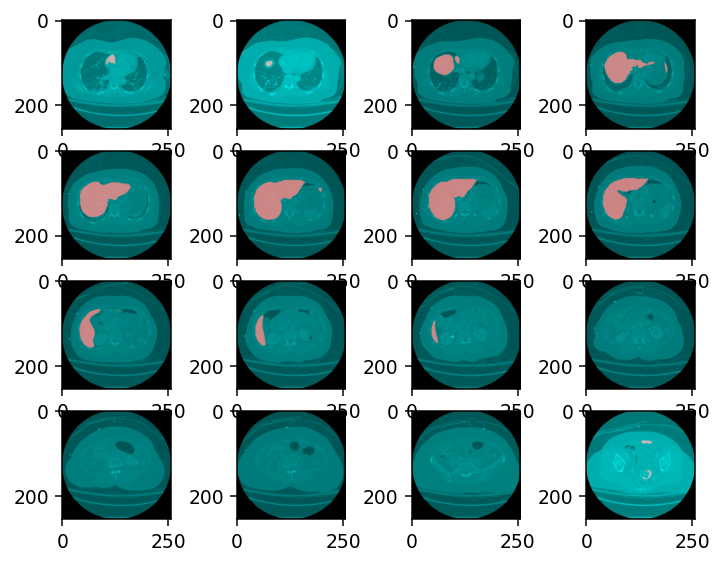

In [65]:
show_df = trn_df.iloc[np.random.randint(0, len(trn_df))]
show_files = glob(f"./{folder}/{show_df.patient_id}_{show_df.series_id}_{org_segs[0]}_*.jpeg")
show_files = glob(f"./{folder}/{show_df.patient_id}/{show_df.series_id}/*_*_{org_segs[0]}_*.jpeg")
show_files = sorted(show_files,key=lambda x:int(x.split("_")[-1].split(".")[0]))
print(len(show_files))
show_tensor = prepare_resnet18lstm_images(show_files)

for ii in range(16):
    show_slice = int(show_tensor.shape[0]/16*ii)
    print(show_tensor.shape)
    show_mask = show_tensor[show_slice][0]
    show_jpg = show_tensor[show_slice][1]
    plt.subplot(4,4,ii+1);plt.imshow(np.stack([show_mask,show_jpg,show_jpg],axis=2).astype(np.int32))

In [83]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        resnet = torchvision.models.resnet18()
        resnet.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        self.ltsm = nn.LSTM(input_size=512, hidden_size=128, batch_first=True)
        # self.fc = nn.Linear(in_features=128*SLICE_NUM, out_features=len(TARGET_COLS))
        self.fc = nn.Linear(in_features=128*VOLUME[0], out_features=len(target_cols))
    
    def forward(self, x):
        
        batch_size = x.shape[0]
        # x = x.view(batch_size * SLICE_NUM, WINDOW_WIDTH, VOLUME[1], VOLUME[2])
        x = x.view(batch_size * VOLUME[0], 2, VOLUME[1], VOLUME[2])
        x = self.backbone(x)
        # x = x.view(batch_size, SLICE_NUM, -1) 
        x = x.view(batch_size, VOLUME[0], -1) 
        
        x, _ = self.ltsm(x)
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc(x)
        
        return x

In [123]:
model = Net().to("cuda")
model_path = f"./models/resnet18LSTM/resnet18_{org_name}_128_{VOLUME[1]}_{VOLUME[2]}_ep1_fold0_{len(target_cols)}labels_1008.pth"
print(model_path)
model.load_state_dict(torch.load(model_path))
model_name = f"resnet18"

./models/resnet18LSTM/resnet18_liver_128_256_256_ep1_fold0_3labels_1008.pth


In [67]:
llines = []
count = 0
gt_l, pred_l,pred_pid = [],[],[]
print("reading ", f"./logs/{model_name}_{org_name}_ep{epoch}_fold{fold}_3labels_{version}.txt")
ff = open(f"./logs/{model_name}_{org_name}_ep{epoch}_fold{fold}_3labels_{version}.txt","r")
for ll in ff.readlines():
    # print(count%2)
    count+=1
    if 'train' in ll: continue
    if not ll.startswith("["):
        pred_pid.append(ll.split(" ")[0])
    else:
        # print(ll)
        llist = ll.replace("]","").replace("[","").split()
        # print(llist)
        gt_l.append([float(x) for x in llist[:3]])
        pred_l.append([float(x) for x in llist[3:]])
len(gt_l), len(pred_l)

reading  ./logs/resnet34_2ch_liver_ep3_fold0_3labels_1008.txt


(0, 0)

In [93]:
print(model_name,target_cols,org_name,org_segs,folder,version)


resnet34 ['spleen_healthy', 'spleen_low', 'spleen_high'] spleen ['2'] cropped_organs_sid 1008


In [107]:

model_name = "resnet34"
model_name = "resnet34_2ch"
model = torchvision.models.resnet34(False)
model.load_state_dict(torch.load("G:/rsna-2023-abdominal-trauma-detection/resnet34-333f7ec4.pth"))
model.fc = torch.nn.Linear(512, 3)
model.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load(f"./models/single/resnet_liver_ep0_fold0_3labels_1008_bal.pth", map_location=torch.device('cpu')))

raw_model = torchvision.models.resnet34(False)
raw_model.fc = torch.nn.Linear(512, 3)
raw_model.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
raw_model.load_state_dict(torch.load(f"./models/single/resnet_liver_ep0_fold0_3labels_1008_2ch.pth", map_location=torch.device('cpu')))
raw_model=raw_model.cuda()

e:\Anaconda\envs\tt\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
e:\Anaconda\envs\tt\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [112]:
from PIL import Image 
model = model.cuda()
gt_target = []
pred_target = []
images_coords = [239-112, 180-112]
test_image_list = []
test_image_list2 = []
# cls 3 lkidney 300.0794, 345.5285
# cls 2 spleen 304, 380
# cls 5 bowel 214 287
# cls 1 liver 239 180
# cls 4 rkidney 183,183
from torchvision.transforms import transforms
torch_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

if not os.path.exists(f"./logs/{model_name}_{org_name}_ep{epoch}_fold{fold}_3labels_{version}.txt"):
    fw = open(f"./logs/{model_name}_{org_name}_ep{epoch}_fold{fold}_3labels_{version}.txt","w")
    fw.close()
test_df = trn_df[trn_df[target_cols[0]]==0]
test_input = []
print("neg size", test_df.shape)
pos_len = len(trn_df)-len(test_df)
test_df = pd.concat([test_df,trn_df[trn_df.liver_healthy==1].iloc[np.random.choice(pos_len,len(test_df))]],axis=0)
for col in target_cols:
    print(col, np.sum(test_df[col].values))
print(len(test_df))
print("train pids", len((trn_df.patient_id.values)),len(test_df))
for pid in np.unique(test_df[:].patient_id.values):
    # if str(pid) in pred_pid:
    #     print("skipping ", pid)
    # print(pid)
    sids = glob(f"./train_images/{pid}/*")
    sids = [int(x.split("\\")[-1].split(".")[0]) for x in sids]
    fw = open(f"./logs/{model_name}_{org_name}_ep{epoch}_fold{fold}_3labels_{version}.txt","a")
    fw.write(str(pid)+" "+str(len([]))+"\n")

    # gt_target.append(tmp_df.iloc[0][f"{target_col}"])
    # if np.sum(tmp_df.iloc[0][target_cols].values == np.array([1,0,0]))==3: continue
    for sid in sids:
        image_paths = []
        if org_name != "all":
            for org_seg in org_segs:
                image_paths += glob(f"./{folder}/{pid}/{sid}/*_*_{org_seg}_*.jpeg")
            image_paths = sorted(image_paths,key=lambda x:int(x.split("_")[-1].split(".")[0]))
        else:
            image_paths = glob(f"./train_images/{pid}/*/*.dcm")
            image_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{pid}/*/*.jpeg")

        # image_paths = np.random.choice(image_paths,15)
        # image_paths = image_paths[:15]
        # print(image_paths[:5])
        if not len(image_paths):
            print("empty file")
            continue
        tmp_df = trn_df[trn_df.patient_id==pid]
        gt_target.append(tmp_df.iloc[0][target_cols].values)
        test_image_list.append([])
        test_image_list2.append([])
        img_list = []
        if "resnet18" in model_name:
            img_tensor = prepare_resnet18lstm_images(image_paths).cuda()
            raw_model = Net().to("cuda")
            raw_model.load_state_dict(torch.load("./models/resnet18LSTM/resnet18_spleen_128_256_256_ep1_fold0_3labels_1008.pth"))
            model_out = torch.sigmoid(model(torch.unsqueeze(img_tensor,0).cuda()).data.cpu())
            raw_model_out = torch.sigmoid(raw_model(torch.unsqueeze(img_tensor,0).cuda()).data.cpu())
            
            print("resnet18", model_out,raw_model_out,gt_target[-1])
        elif model_name == "resnet34":
            for ii in range(0, len(image_paths)):
                # print((torch_transform(Image.open(image_paths[ii]))[0:1]*1.0).max())
                img_list.append(torch_transform(Image.open(image_paths[ii]))[0:1]*255.0)
                # print(img_list[-1].shape)
            # print(torch.stack(img_list,0).shape)
            model_out = torch.sigmoid(model(torch.stack(img_list,0).cuda())).data.cpu()
            print("model out", model_out)
        elif model_name == "resnet34_2ch":
            images = prepare_2ch_images(image_paths)
            test_input.append(images)
            rets = []
            raw_rets = []
            for idx in range(0, len(images),5):
                model_out = torch.sigmoid(model(torch.Tensor(images[idx:idx+5]).cuda()).data.cpu())
                raw_model_out = torch.sigmoid(raw_model(torch.Tensor(images[idx:idx+5]).cuda()).data.cpu())
                # print("model out", model_out.shape,raw_model_out.shape)
                rets.append(np.array(model_out))
                raw_rets.append(np.array(raw_model_out))
            rets = np.mean(np.concatenate(rets),axis=0)
            raw_rets = np.mean(np.concatenate(raw_rets),axis=0)
            # print("ret shape", rets.shape, raw_rets.shape)
            print("pid sid",pid, sid, rets,raw_rets,gt_target[-1])
        elif model_name == "gru":
            image = prepare_gru_images(image_paths)
            print("resnet18 image shape", image.shape)
        # print(model_input.shape)
        # model_out = model(model_input).data.cpu()
            print(model_out)
    # print(model_out.shape)
    # print(gt_target[-1])
    # fw.write(str(gt_target[-1])+" "+str(pred_target[-1])+"\n")
    fw.close()
    torch.cuda .empty_cache()

neg size (475, 16)
liver_healthy 475
liver_low 384
liver_high 91
950
train pids 4711 950
pid sid 33 55570 [0.5048472  0.39541394 0.0744066 ] [0.90633637 0.07765183 0.01621325] [0 1 0]
pid sid 43 24055 [0.5032452  0.39588693 0.08019466] [0.9074897  0.07934678 0.01552215] [1 0 0]
pid sid 43 36714 [0.5009355  0.3932051  0.07959937] [0.9069167  0.07919174 0.01521871] [1 0 0]
pid sid 384 48600 [0.49836588 0.39919674 0.08620743] [0.90345603 0.07877338 0.0164869 ] [1 0 0]


KeyboardInterrupt: 

In [116]:
len(test_input)

5

In [117]:
test_input[0].shape

(105, 2, 512, 512)

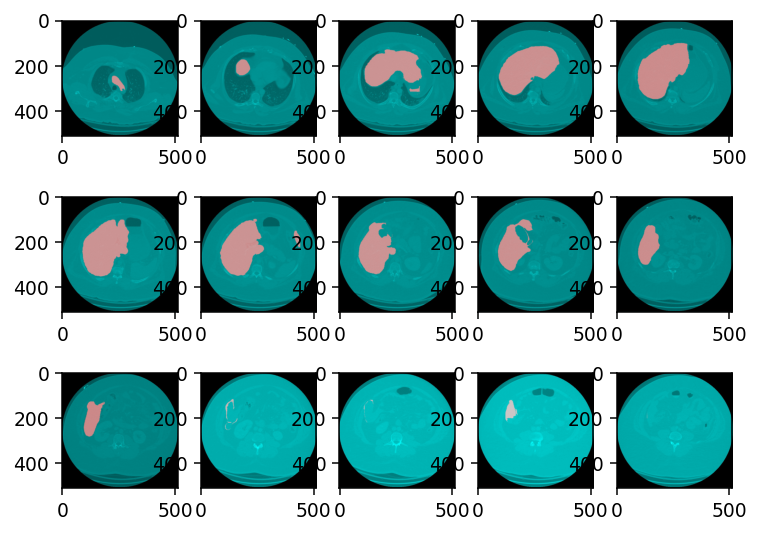

In [122]:
show_tensor = test_input[0]
for ii in range(15):
    idx = int(show_tensor.shape[0]/15.0*ii)
    show_img = show_tensor[idx][0]
    show_mask = show_tensor[idx][1]

    plt.subplot(3,5,ii+1);
    plt.imshow(np.stack([show_mask,show_img,show_img],axis=2))

In [ ]:
len(test_image_list)
test_image_list[1][0].max()
# test_image_list2[0][0]
len(test_image_list[0]),test_image_list[0][0].shape

In [ ]:
# test_image_list[0][0][0][110:130,110:130]

In [ ]:
llines = []
count = 0
gt_l, pred_l,pred_pid = [],[],[]
ff = open(f"./logs/{model_name}_{org_name}_ep{epoch}_fold{fold}_3labels_{version}.txt","r")
for ll in ff.readlines():
    # print(count%2)
    count+=1
    if 'train' in ll: continue
    if not ll.startswith("["):
        pred_pid.append(ll.split(" ")[0])
    else:
        # print(ll)
        llist = ll.replace("]","").replace("[","").split()
        # print(llist)
        gt_l.append([float(x) for x in llist[:3]])
        pred_l.append([float(x) for x in llist[3:]])
len(gt_l), len(pred_l)

In [ ]:
for ii in range(6):
    plt.subplot(2,3,ii+1);plt.imshow(test_image_list[ii][0])

In [ ]:
pred_l[:10],gt_l[:10]

In [ ]:
# gt_e3, pred_e3 = gt_target, pred_target
gt_e3, pred_e3 = gt_l, pred_l
from sklearn.metrics import log_loss
log_loss([[x[0],x[1],x[2]] for x in gt_e3[:1493]], [[y[0],y[2],y[1]] for y in pred_e3])

In [ ]:
log_loss([[x[1],x[2],x[0]] for x in gt_e3[:1493]], [[y[0],y[1],y[2]] for y in pred_e3])

In [ ]:
log_loss([[0,1,0] for x in gt_e3[:1493]], [[y[0],y[1],y[2]] for y in pred_e3])

In [ ]:

target_cols = ["spleen_healthy","spleen_low","spleen_high"]
model.load_state_dict(torch.load("./models/vit_spleen_3_3labels_0927.pth", map_location=torch.device('cpu')))


In [ ]:
gt_target = []
pred_target = []
images_coords = [239-112, 180-112]
print("train pids", len(np.unique(trn_df.patient_id.values)))
for pid in np.unique(trn_df.patient_id.values):
    tmp_df = trn_df[trn_df.patient_id==pid]
    # gt_target.append(tmp_df.iloc[0][f"{target_col}"])
    if np.sum(tmp_df.iloc[0][target_cols].values == np.array([1,0,0]))==3: continue
    gt_target.append(tmp_df.iloc[0][target_cols].values)
    img_list = []
    image_paths = glob(f"./train_images/{pid}/*/*.dcm")
    # image_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{pid}/*/*.jpeg")
    fw = open("./logs/resnet_liver_3_3labels_0927.txt","a")
    fw.write(str(pid)+" "+str(len(image_paths))+"\n")
    for iid in range(0, len(image_paths),16):
        img_list = []
        for jj in range(min(16,len(image_paths)-iid)):
            img = load_dicom(image_paths[iid+jj])
            # img = cv2.imread(image_paths[iid+jj])[:,:,0]
            # print("minmax", img.max(),img.min())
            img_tmp = img[images_coords[0]:images_coords[0]+224,images_coords[1]:images_coords[1]+224]
            img_tmp = torch.tensor(img_tmp.astype(np.float32)).to(torch.float32)
            img_tmp = torch.unsqueeze(img_tmp,0)
            img_list.append(img_tmp)
    torch.cuda.empty_cache()
    pred_target.append(np.mean(np.array(model(torch.stack(img_list,0).cuda()).data.cpu()),axis=0))

    fw.write(str(gt_target[-1])+" "+str(pred_target[-1])+"\n")
    fw.close()

In [ ]:
print(len(img_list),img_list[0].max())
plt.imshow(np.squeeze(img_list[0]))

In [ ]:
# model = torchvision.models.resnet34(False)
# # model.load_state_dict(torch.load("G:/rsna-2023-abdominal-trauma-detection/resnet34-333f7ec4.pth"))
# model.fc = torch.nn.Linear(512, 14)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model = model.cuda()
# model.load_state_dict(torch.load("./models/official_model_0.pth", map_location=torch.device('cpu')))
import timm
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=False,
    num_classes=3,
    in_chans=1
)
model = model.to("cuda")
# model.load_state_dict(torch.load(f"./models/vit0919_model_3_0.pth", map_location=torch.device('cpu')))

model.load_state_dict(torch.load(f"./models/vit_spleen_3_3labels_0927.pth", map_location=torch.device('cpu')))

In [ ]:
trn_df.columns

In [ ]:
gt_target = []
pred_target = []
images_coords = [239-112, 180-112]
test_img_list = []

import torchvision.transforms as transforms
# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.RandomVerticalFlip(0.5),  # Resize the image to 224x224 pixels
    transforms.RandomHorizontalFlip(0.5),  # Resize the image to 224x224 pixels
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

from PIL import Image
print("train pids", len(np.unique(trn_df.patient_id.values)))
for pid in np.unique(trn_df.patient_id.values):
    tmp_df = trn_df[trn_df.patient_id==pid]
    if np.sum(tmp_df.iloc[0].values[1:]==np.array([1,0,1,0,1,0,0,1,0,0,1,0,0,0]))==14: continue
    gt_target.append(tmp_df.iloc[0].values[1:])
    img_list = []
    # image_paths = glob(f"./train_images/{pid}/*/*.dcm")
    image_paths = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{pid}/*/*.jpeg")
    fw = open("./logs/vit_spleen_3_3labels_0927.txt","a")
    fw.write(str(pid)+" "+str(len(image_paths))+"\n")
    for iid in range(0, len(image_paths),16):
        img_list = []
        for jj in range(min(16,len(image_paths)-iid)):
            img = load_dicom(image_paths[iid+jj])
            # img = cv2.imread(image_paths[iid+jj])[:,:,0]
            # print("minmax", img.max(),img.min())
            img_tmp = img[images_coords[0]:images_coords[0]+224,images_coords[1]:images_coords[1]+224]
            img_tmp = torch.tensor(img_tmp.astype(np.float32)).to(torch.float32)
            img_tmp = torch.unsqueeze(img_tmp,0)
            img_list.append(img_tmp)
    torch.cuda.empty_cache()
    pred_target.append(np.mean(np.array(model(torch.stack(img_list,0).cuda()).data.cpu()),axis=0))

    fw.write(str(gt_target[-1])+" "+str(pred_target[-1])+"\n")
    fw.close()

In [ ]:
from sklearn.metrics import log_loss
log_loss([[x[0],x[1]] for x in gt_target[:82]], [[y[0],y[1]] for y in pred_target])

In [ ]:
log_loss([[1,0] for x in gt_target[:82]], [[0,1] for y in pred_target])

In [ ]:
# jpeg result
# [19  1  0  1  0  1  0  0  1  0  0  1  0  0  0]
# [ 3.880985   -3.2030618   2.735263   -1.0913178   2.805019   -2.6235838
#  -2.3841937   2.2705293  -1.8202534  -2.8157544   2.2294354  -2.2137241
#  -1.7917032   0.60871875]
# [26  1  0  1  0  1  0  0  1  0  0  1  0  0  0]
# [ 3.4438732  -2.8389065   2.4283643  -0.92939484  2.474575   -2.3635507
#  -2.1204333   1.9803826  -1.583797   -2.4700587   1.9643123  -1.9380245
#  -1.5670626   0.62710434]
# [33  0  1  0  1  1  0  0  0  1  0  1  0  0  1]
# [ 3.3344412  -2.7624295   2.341146   -0.88833064  2.3989904  -2.295598
#  -2.056854    1.9248023  -1.5347817  -2.4008102   1.8959575  -1.8815002
#  -1.5093359   0.63732594]
# [43  0  1  0  1  1  0  0  1  0  0  1  0  0  1]
# [ 3.0672069  -2.5082462   2.1541572  -0.80345905  2.2020352  -2.10112
#  -1.8401673   1.7655265  -1.4397556  -2.181815    1.713845   -1.7100222
#  -1.3423375   0.56748486]
# [96  1  0  1  0  1  0  0  1  0  0  1  0  0  0]
# [ 3.8751016 -3.202003   2.7128704 -1.05266    2.8093636 -2.6432385
#  -2.3974533  2.2755766 -1.8386105 -2.8253448  2.2139492 -2.1950023
#  -1.7747941  0.6143919]
# [122   1   0   1   0   1   0   0   1   0   0   1   0   0   0]
# [ 3.8364632  -3.164506    2.7084048  -1.0604161   2.7702844  -2.6077554
#  -2.3668184   2.2365706  -1.8099858  -2.7918317   2.1762967  -2.1802473
#  -1.750591    0.60438234]
# ...
# [965   1   0   1   0   1   0   0   1   0   0   1   0   0   0]
# [ 3.9191608 -3.2275395  2.73539   -1.1008857  2.8314385 -2.6650176
#  -2.422104   2.2649255 -1.8191825 -2.8263087  2.2267163 -2.2004952
#  -1.7873621  0.6330269]


In [ ]:
len(test_img_list)
# len(test_img_list[2])
gt_target = []
pred_target = []
images_coords = [239-112, 180-112]
test_img_list = []
torch.cuda.empty_cache()

In [ ]:
# 19 673
# 0 -2.7192452
# 26 353
# 0 -2.6122086
# 33 205
# 0 -2.5792964
# 43 276
# 0 -2.6082425
# 96 259
# 0 -2.6442888
# 122 300
# 0 -2.541759
# 156 188
# 0 -2.5377064
# 187 116
# 0 -2.6029012
# 201 707
# 0 -2.6083965
# 205 123
# 0 -2.588951
# 222 1124
# 0 -2.6726527
# 263 191
# 0 -2.5570443
# 273 228
# 0 -2.610641
# 310 182
# 0 -2.577021
# 318 667
# 0 -2.5692456
# 384 110
# 0 -2.4985313
# 386 1272
# 0 -2.5919037
# 394 221
# 0 -2.5924683
# 403 889
# 0 -2.5933948
# 429 671
# 0 -2.6257856
# 430 299
# 0 -2.5174704
# 470 206
# 0 -2.4993148
# 496 133
# 0 -2.5928555
# 521 250
# 0 -2.5582488
# 531 775
# 0 -2.606113
# 537 252
# 0 -2.5561593
# 581 342
# 0 -2.5826797
# 590 598
# 0 -2.5031264
# 622 169
# 0 -2.601633
# 639 752
# 0 -2.6001048
# 648 119
# 0 -2.5375724
# 687 226
# 0 -2.5750065
# 697 845
# 0 -2.5278215
# 706 483
# 0 -2.5813468
# 716 199
# 0 -2.5979202
# 732 277
# 0 -2.6048796
# 766 962
# 0 -2.6498103
# 796 554
# 0 -2.5718637
# 820 421
# 0 -2.5957878
# 821 695
